In [ ]:
!pip install numpy==1.19.3
!pip install mediapipe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import zipfile
import glob

from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam

## Read Hand Pose Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Deep Learning/FC_NN_HandPose_Classifier/'
data_list = glob.glob(data_dir + '*.zip')

In [17]:
for data_path in data_list:
  f_name = data_path.split('/')[-1]
  with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall('./handpose_data')

In [18]:
import re
from pathlib import Path

def get_numbers_from_filename(filename):
  return int(re.search(r'\d+', filename).group(0))


def get_class_form_filename(file_name):
  return Path(file_name).stem

csv_list = glob.glob('./handpose_data/*.csv')
dataframes_list = []
labels_data = []
label_num = -1
class_names = []
for file_name in csv_list:
  df = pd.read_csv(file_name)
  dataframes_list.append(df)                                # lista con dataFrames para concatenar en un unico df

  #if csv files include class number
  #label_num = get_numbers_from_filename(file_name)

  #if csv files include class names
  class_names.append(get_class_form_filename(file_name))
  label_num += 1 
  labels_data.append((label_num, df.shape[0]))               # lista con tuples (label, longitud) segun cada csv

labels = np.concatenate([label*np.ones(lenght) for label, lenght in labels_data])
categorical_labels = to_categorical(labels, num_classes=len(labels_data))
features_df = pd.concat(dataframes_list)
features = features_df.iloc[:,:].values
num_features = features.shape[1]
num_training_samples = features.shape[0]
num_classes = categorical_labels.shape[1]
print("numero de features = ", num_features)
print("numero de clases = ", num_classes)
print("numero de muestras para entrenamiento = ", num_training_samples)

numero de features =  63
numero de clases =  8
numero de muestras para entrenamiento =  18681


In [14]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,0.182378,0.627964,5.103543e-07,0.243018,0.602040,-0.030214,0.291685,0.551277,-0.045960,0.318112,0.499373,-0.061527,0.314021,0.456941,-0.074506,0.249238,0.468739,0.012462,0.247415,0.413188,-0.008428,0.244031,0.382283,-0.046202,0.238895,0.377588,-0.078388,0.215196,0.460260,0.012128,0.210128,0.403009,-0.010817,0.211857,0.372990,-0.049679,0.213242,0.379432,-0.081107,0.182020,0.464090,0.006818,0.177762,0.409641,-0.012727,0.182902,0.382312,-0.044029,0.188621,0.384362,-0.067239,0.148558,0.479314,-0.001793,0.147891,0.426193,-0.025741,0.154024,0.399546,-0.045792,0.164800,0.392175,-0.060581
1,0.186118,0.630093,-2.031531e-06,0.245832,0.601019,-0.023619,0.294754,0.549628,-0.037358,0.320951,0.498760,-0.052995,0.312685,0.457592,-0.064943,0.249812,0.466355,0.019330,0.245939,0.411804,-0.002956,0.243463,0.384164,-0.037657,0.241239,0.381892,-0.065391,0.215740,0.460367,0.014658,0.209535,0.404184,-0.007543,0.210930,0.373832,-0.044140,0.213175,0.377304,-0.073006,0.182634,0.466674,0.005281,0.177764,0.414088,-0.014950,0.181406,0.384674,-0.045614,0.187182,0.381868,-0.067463,0.149686,0.483881,-0.007342,0.150777,0.432479,-0.031899,0.155682,0.403540,-0.051459,0.165231,0.389297,-0.066516
2,0.181318,0.628636,6.663703e-06,0.241523,0.601033,-0.025628,0.290910,0.549499,-0.038736,0.317596,0.498103,-0.053015,0.312831,0.457708,-0.064653,0.249848,0.470332,0.015757,0.247347,0.415546,-0.006995,0.243680,0.386647,-0.043665,0.238888,0.379897,-0.073792,0.216184,0.462510,0.011445,0.212942,0.406971,-0.012052,0.213594,0.376525,-0.049061,0.213763,0.375994,-0.079019,0.182648,0.466678,0.002629,0.181334,0.414230,-0.017950,0.184785,0.384607,-0.047708,0.189679,0.379676,-0.070461,0.148367,0.481528,-0.009626,0.149886,0.430851,-0.032044,0.155735,0.402492,-0.049928,0.166199,0.388107,-0.064001
3,0.182518,0.627508,3.329910e-06,0.242625,0.601773,-0.027520,0.289829,0.550861,-0.038590,0.315195,0.499959,-0.050099,0.315250,0.458799,-0.059518,0.250115,0.470052,0.026041,0.249440,0.415549,0.011007,0.245381,0.384579,-0.024404,0.239108,0.375496,-0.056583,0.216522,0.461721,0.026064,0.212072,0.404716,0.008675,0.212665,0.374874,-0.031053,0.213201,0.376047,-0.063734,0.184194,0.465465,0.021092,0.179906,0.411210,0.005713,0.183845,0.383513,-0.025229,0.188755,0.380254,-0.047911,0.151329,0.480643,0.012572,0.150884,0.428999,-0.006577,0.156002,0.401223,-0.024506,0.165931,0.387344,-0.038082
4,0.182341,0.624650,-9.303948e-06,0.244017,0.598806,-0.025302,0.292201,0.548770,-0.036343,0.318189,0.497223,-0.048334,0.315219,0.454729,-0.058068,0.251929,0.468856,0.024231,0.250400,0.415621,0.006902,0.246832,0.385346,-0.029002,0.240970,0.376939,-0.059866,0.218064,0.460641,0.022152,0.213139,0.405313,0.003075,0.214689,0.374813,-0.035552,0.215378,0.375325,-0.066919,0.184986,0.463903,0.015102,0.180318,0.410194,-0.002108,0.184906,0.382344,-0.032419,0.189789,0.380237,-0.055223,0.151446,0.477660,0.004891,0.150897,0.425243,-0.015615,0.156397,0.397713,-0.033968,0.166387,0.387106,-0.047993


## Draw Hand Landmarks

In [7]:
import math
from typing import List, Tuple, Union
import mediapipe as mp


def _normalized_to_pixel_coordinates(normalized_x: float, normalized_y: float, image_width: int, image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def draw_landmarks(image: np.ndarray, landmarks: np.ndarray, connections: List[Tuple[int, int]] = None):
  """Draws the landmarks and the connections on the image.
  Args:
    image: A three channel RGB image represented as numpy ndarray.
    landmarks: A normalized landmark numpy array 
    connections: A list of landmark index tuples that specifies how landmarks to be connected in the drawing.
  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel RGB.
      b) If any connetions contain invalid landmark index.
  """
  if image.shape[2] != 3:
    raise ValueError('Input image must contain three channel rgb data.')
  image_rows, image_cols, _ = image.shape
  idx_to_coordinates = {}
  for idx in range(21):
    landmark_px = _normalized_to_pixel_coordinates(landmarks[3*idx], landmarks[3*idx+1], image_cols, image_rows)
    if landmark_px:
      idx_to_coordinates[idx] = landmark_px
  if connections:
    num_landmarks = 21
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
        cv2.line(image, idx_to_coordinates[start_idx], idx_to_coordinates[end_idx], (0, 255, 0), 2)
  
  # Draws landmark points after finishing the connection lines, which is aesthetically better.
  for landmark_px in idx_to_coordinates.values():
    cv2.circle(image, landmark_px, 2, (255, 0, 0), 2)

In [8]:
hand_connections = mp.solutions.hands.HAND_CONNECTIONS

def plot_random_pose(features, labels, indexes):
  plt.figure(figsize=(15, 15))
  for i in range(25):
    img = np.zeros((200, 200, 3), dtype = "uint8")
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    hand_landmarks = features.iloc[indexes[i]].values
    draw_landmarks(img, hand_landmarks, hand_connections)
    plt.imshow(img)
    plt.xlabel(class_names[labels[indexes[i]]])
plt.show()

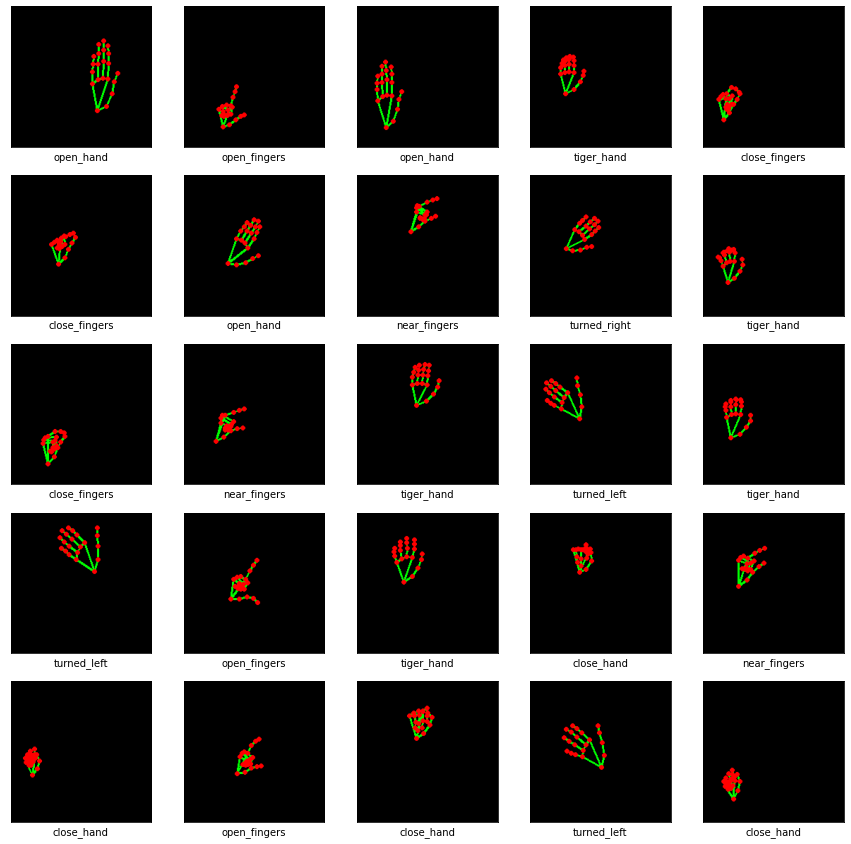

In [19]:
#class_names = ['open', 'fist', 'peace', 'ok']
plot_random_pose(features_df, np.argmax(categorical_labels, axis=1), np.random.randint(len(labels), size=25))

## Neural Network Training

In [ ]:
def plot_history(history, title):
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])    
    plt.title(title +' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title +' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def plot_multi_hist_loss(hist_list, title, legen1, legen2, legen3='None'):
    for i in range(len(hist_list)):
        plt.plot(hist_list[i].history['loss'])
        plt.plot(hist_list[i].history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    legends = [legen1+' train', legen1+' test', legen2+' train', legen2+' test']
    if len(hist_list) == 3:
        legends.append(legen3+' train')
        legends.append(legen3+' test')
    plt.legend(legends, loc='upper right')
    plt.show()
    
def keras_model(layers_dims, learning_rate, dropout=0.0):
    L = len(layers_dims)
    modelo = Sequential()
    modelo.add(Dense(layers_dims[1], input_dim=layers_dims[0], activation="relu"))
    if dropout != 0:
        modelo.add(Dropout(dropout))
    for i in range(2, L - 1):
        modelo.add(Dense(layers_dims[i], activation="relu"))
        if dropout != 0:
            modelo.add(Dropout(dropout))

    modelo.add(Dense(layers_dims[L - 1], activation="softmax"))
    modelo.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return modelo

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(features, categorical_labels, test_size=0.2)

## Model Comparison

In [ ]:
three_models = np.array([[63, 20, 10, 4], [63, 70, 25, 4], [63, 50, 20, 4]])
hist = []
for i in range(three_models.shape[0]):
    model = keras_model(three_models[i], 0.001, dropout=0.6)
    hist.append(model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=200, batch_size=400, verbose=0))

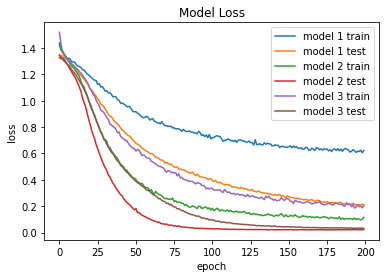

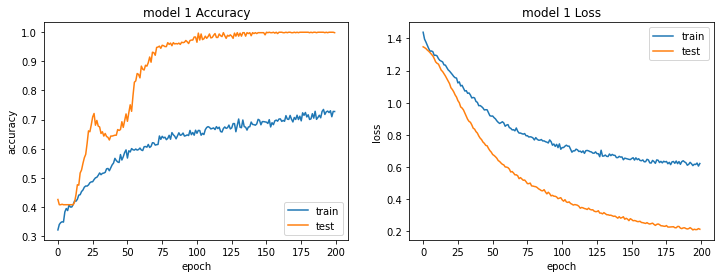

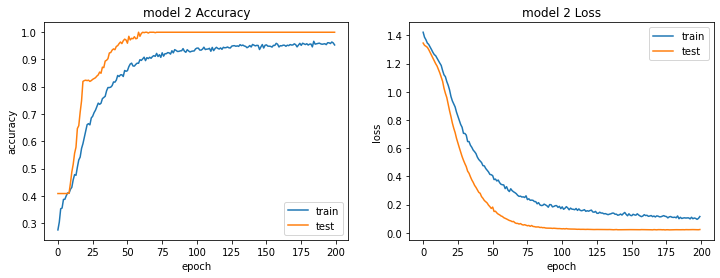

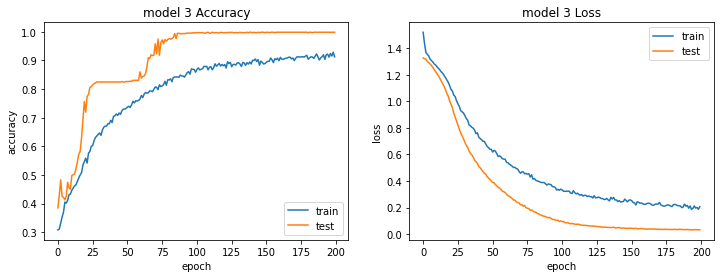

In [ ]:
plot_multi_hist_loss(hist, 'Model Loss', 'model 1', 'model 2', 'model 3')
plot_history(hist[0], 'model 1')
plot_history(hist[1], 'model 2')
plot_history(hist[2], 'model 3')

## Definitive Model

In [ ]:
model = keras_model([63, 70, 25, 4], 0.001, dropout=0.6)
hist = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=200, batch_size=400, verbose=1)

Epoch 1/200
7/7 [==============================] - 1s 72ms/step - loss: 1.4608 - accuracy: 0.2985 - val_loss: 1.3178 - val_accuracy: 0.3923
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 1.3816 - accuracy: 0.3186 - val_loss: 1.3134 - val_accuracy: 0.3923
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 1.3382 - accuracy: 0.3677 - val_loss: 1.3087 - val_accuracy: 0.3923
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 1.3339 - accuracy: 0.3638 - val_loss: 1.2939 - val_accuracy: 0.3938
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 1.3199 - accuracy: 0.3795 - val_loss: 1.2792 - val_accuracy: 0.4042
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 1.3030 - accuracy: 0.4141 - val_loss: 1.2642 - val_accuracy: 0.4428
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 1.2779 - accuracy: 0.4208 - val_loss: 1.2440 - val_accuracy: 0.4532
Epoch 8/200
7/7 [=========

In [ ]:
# Evaluate the model and make prediction
loss, acc = model.evaluate(test_x, test_y, verbose=2)
output = model.predict(features_df.iloc[0].values.reshape((1, 63)))
print('predicted class: {}, with propability {}%'.format(class_names[np.argmax(output)], np.max(output)*100))
print('annotated class: {}'.format(class_names[int(labels[0])]))

22/22 - 0s - loss: 0.0019 - accuracy: 1.0000
[[6.9644706e-08 9.9976081e-01 7.7582814e-07 2.3829167e-04]]
predicted class: fist, with propability 99.97608065605164%
annotated class: fist


In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('./handpose_data/saved_model') 

In [ ]:
!zip -r './handpose_data/handpose_classifier_model.zip' './handpose_data/saved_model'

  adding: handpose_data/saved_model/ (stored 0%)
  adding: handpose_data/saved_model/assets/ (stored 0%)
  adding: handpose_data/saved_model/variables/ (stored 0%)
  adding: handpose_data/saved_model/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: handpose_data/saved_model/variables/variables.index (deflated 62%)
  adding: handpose_data/saved_model/saved_model.pb (deflated 88%)


In [ ]:
from google.colab import files
files.download('./handpose_data/handpose_classifier_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>